In [35]:
!python --version
import os
print(f"Number of CPU cores available: {os.cpu_count()}")

Python 3.12.12
Number of CPU cores available: 12


***DATASET***


In [36]:
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')

Data source import complete.


In [ ]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(mlg_ulb_creditcardfraud_path, 'creditcard.csv')
df = pd.read_csv(data_path)


# Turn the continuous stopwatch into a 24-hour clock
df['SecondsInDay'] = df['Time'] % 86400

# Calculate Density
df['TransactionDensity'] = df['Amount'] / (df['SecondsInDay'] + 1)

df.fillna(df.mean(numeric_only=True), inplace=True) # Fils N/A

features_to_scale_names = ['Amount', 'TransactionDensity'] # Because PCA is already scaled
pca_features = [f'V{i}' for i in range(1, 29)]

X = df[features_to_scale_names + pca_features].copy()
y = df['Class']

print(f"Full dataset ready for splitting. Total records: {len(df)}")
print(f"Fraud ratio: {y.mean():.4%}")
print(f"Fraud cases: {y.sum()}")

Full dataset ready for splitting. Total records: 284807
Fraud ratio: 0.1727%
Fraud cases: 492


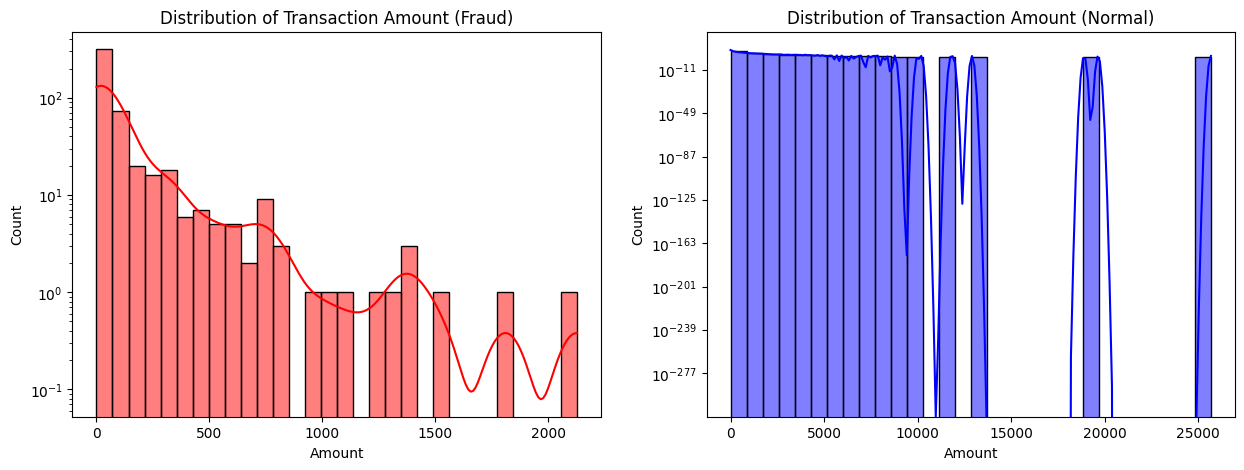

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of Amount for Fraud
sns.histplot(df[df['Class'] == 1]['Amount'], bins=30, ax=ax1, kde=True, color='red')
ax1.set_title('Distribution of Transaction Amount (Fraud)')
ax1.set_yscale('log') # Log scale because amounts vary wildly

# Distribution of Amount for Normal
sns.histplot(df[df['Class'] == 0]['Amount'], bins=30, ax=ax2, kde=True, color='blue')
ax2.set_title('Distribution of Transaction Amount (Normal)')
ax2.set_yscale('log')

plt.show()

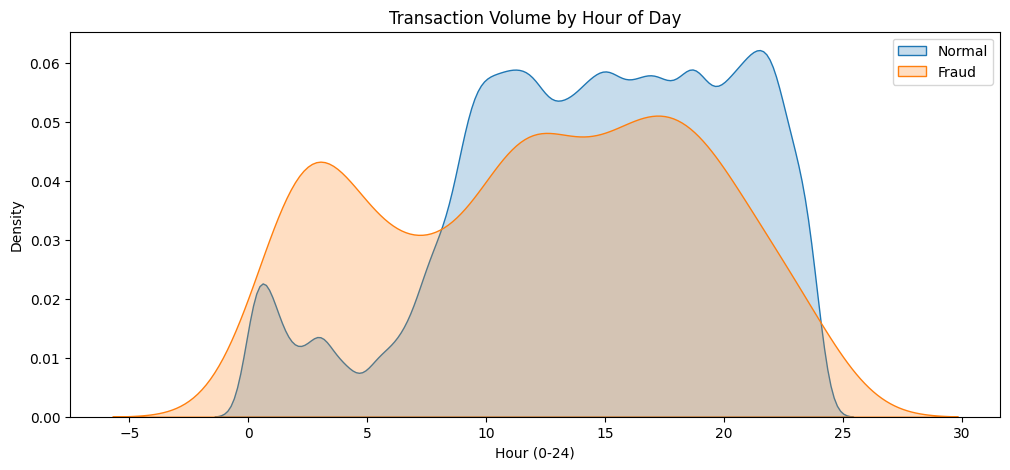

In [39]:
df['Hour'] = (df['Time'] / 3600) % 24

plt.figure(figsize=(12, 5))
sns.kdeplot(df[df['Class'] == 0]['Hour'], label='Normal', fill=True)
sns.kdeplot(df[df['Class'] == 1]['Hour'], label='Fraud', fill=True)
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour (0-24)')
plt.legend()
plt.show()

C:\Users\WIsuy\AppData\Local\Temp\ipykernel_20376\864516982.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=df, palette="Set1")
C:\Users\WIsuy\AppData\Local\Temp\ipykernel_20376\864516982.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=df, palette="Set1")
C:\Users\WIsuy\AppData\Local\Temp\ipykernel_20376\864516982.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y=col, data=df, palette="Set1")
C:\Users\WIsuy\AppData\Local\Temp\ipykernel_20376\864516982.py:6: FutureWarning: 


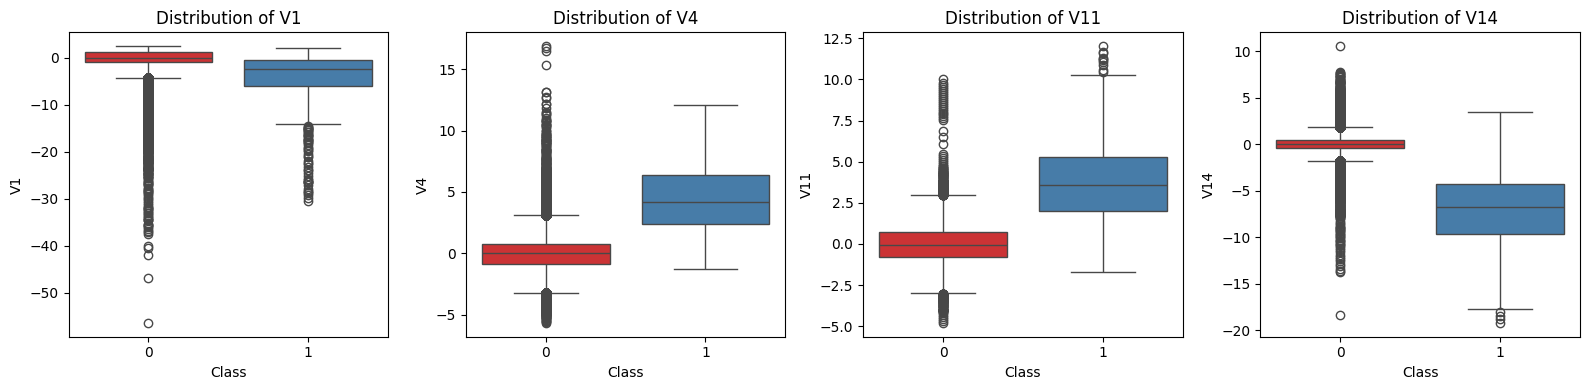

In [40]:
selected_features = ['V1', 'V4', 'V11', 'V14']

plt.figure(figsize=(16, 4))
for i, col in enumerate(selected_features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='Class', y=col, data=df, palette="Set1")
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

***Feature Correlation***

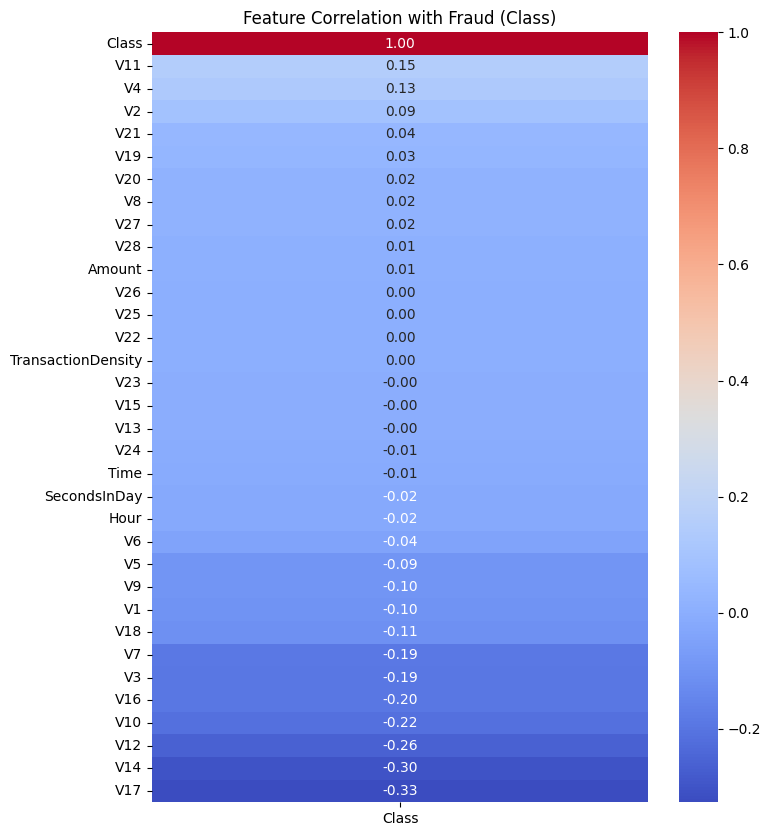

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

corr = df.corr()[['Class']].sort_values(by='Class', ascending=False)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with Fraud (Class)')
plt.show()

***ISOLATION FOREST***


In [42]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling the dataset
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale_names])
X_train[features_to_scale_names] = scaler.transform(X_train[features_to_scale_names])
X_test[features_to_scale_names] = scaler.transform(X_test[features_to_scale_names])

# Isolation Forest
iforest = IsolationForest(contamination=0.01, random_state=42) # contamination='auto' leads to 3.83% outliers
X_train['isOutlier'] = iforest.fit_predict(X_train)
X_test['isOutlier'] = iforest.predict(X_test)

print("Total Anomaly Counts:")
print(X_train['isOutlier'].value_counts())

Total Anomaly Counts:
isOutlier
 1    197370
-1      1994
Name: count, dtype: int64


***UNDERSAMPLING***


In [43]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"Training set size (Balanced): {len(X_train_rus)}")
print(f"Test set size (Real World): {len(X_test)}")
print(f"Fraud Percentage in training data (RUS): {y_train_rus.mean():.4%}")

Training set size (Balanced): 688
Test set size (Real World): 85443
Fraud Percentage in training data (RUS): 50.0000%


***SMOTE***

In [44]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the target size for the majority class
target_size = 10000

# Undersample 'Normal' class to 10,000
rus = RandomUnderSampler(sampling_strategy={0: target_size}, random_state=42)
X_temp, y_temp = rus.fit_resample(X_train, y_train)

# SMOTE 'Fraud' class
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)

print(f"Original Training Fraud Count: {y_train.value_counts()[1]}")
print(f"New Training Set Size: {len(X_train_smote)}")
print(f"New Fraud Count: {sum(y_train_smote == 1)}")
print(f"New Normal Count: {sum(y_train_smote == 0)}")
print(f"Fraud Percentage in training data: {y_train_smote.mean():.4%}")

Original Training Fraud Count: 344
New Training Set Size: 20000
New Fraud Count: 10000
New Normal Count: 10000
Fraud Percentage in training data: 50.0000%


Logistic regression etc.

In [ ]:
import time
import pandas as pd
from sklearn.metrics import recall_score, average_precision_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

performance_data = []

print(f"{'Model':<25} | {'Rec':<6} | {'Prec':<6} | {'F1':<6} | {'AUPRC':<6} | {'Train(s)':<8}")
print("-" * 80)

def record_performance(name, model, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_inf = time.time()
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    inf_time = (time.time() - start_inf)
    inf_time_ms = (inf_time / len(X_test)) * 1000

    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0) 
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auprc = average_precision_score(y_test, y_scores)

    print(f"{name:<25} | {rec:.3f}  | {prec:.3f}  | {f1:.3f}  | {auprc:.3f}  | {train_time:.2f}")

    return {
        "Model": name,
        "Recall": rec,
        "Precision": prec,
        "F1-Score": f1,
        "AUPRC": auprc,
        "Train Time (s)": train_time,
        "Inference Time (ms)": inf_time_ms
    }

# Define the models
models = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')),
    ("LightGBM", LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)),
    ("Linear SVC", LinearSVC(C=1, random_state=42, dual=False))
]

# Run for initial dataset + IF
print("RESULTS INITIAL")
for name, model in models:
    res = record_performance(f"{name} (Initial + IF)", model, X_train, y_train, X_test, y_test)
    performance_data.append(res)

print("-" * 70)

# Run for Undersampling + IF
print("RESULTS RUS")
for name, model in models:
    res = record_performance(f"{name} (RUS)", model, X_train_rus, y_train_rus, X_test, y_test)
    performance_data.append(res)

print("-" * 70)

# Run for RUS + SMOTE + IF
print("RESULTS SMOTE")
for name, model in models:
    res = record_performance(f"{name} (SMOTE)", model, X_train_smote, y_train_smote, X_test, y_test)
    performance_data.append(res)

Model                     | Rec    | Prec   | F1     | AUPRC  | Train(s)
--------------------------------------------------------------------------------
RESULTS INITIAL
Logistic Regression (Initial + IF) | 0.622  | 0.852  | 0.719  | 0.710  | 2.45
Decision Tree (Initial + IF) | 0.723  | 0.781  | 0.751  | 0.565  | 13.73
Random Forest (Initial + IF) | 0.757  | 0.974  | 0.852  | 0.823  | 27.25
Gradient Boosting (Initial + IF) | 0.162  | 0.727  | 0.265  | 0.186  | 227.26
XGBoost (Initial + IF)    | 0.736  | 0.932  | 0.823  | 0.783  | 1.10
LightGBM (Initial + IF)   | 0.459  | 0.276  | 0.345  | 0.178  | 1.13
Linear SVC (Initial + IF) | 0.581  | 0.860  | 0.694  | 0.718  | 1.20
----------------------------------------------------------------------
RESULTS RUS
Logistic Regression (RUS) | 0.878  | 0.058  | 0.109  | 0.599  | 0.01
Decision Tree (RUS)       | 0.885  | 0.013  | 0.026  | 0.012  | 0.01
Random Forest (RUS)       | 0.872  | 0.078  | 0.143  | 0.698  | 0.20
Gradient Boosting (RUS)   | 0.8

***BALANCED RANDOM FOREST***

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Run the Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    sampling_strategy='all',
    replacement=True,
    n_jobs=-1
)

res = record_performance("Balanced RF + IF", brf, X_train, y_train, X_test, y_test)
performance_data.append(res)

Balanced RF + IF          | 0.845  | 0.121  | 0.212  | 0.724  | 2.50


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
import time

def record_nn_performance(name, X_train_data, y_train_data, X_test, y_test):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_data.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    start_train = time.time()
    model.fit(X_train_data, y_train_data, epochs=10, batch_size=128, verbose=0)
    train_time = time.time() - start_train

    start_inf = time.time()
    y_probs = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_probs > 0.5).astype('int32')
    inf_time_ms = ((time.time() - start_inf) / len(X_test)) * 1000

    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auprc = average_precision_score(y_test, y_probs)

    print(f"{name:<25} | {rec:.3f}  | {prec:.3f}  | {f1:.3f}  | {auprc:.3f}  | {train_time:.2f}")

    return {
        "Model": name,
        "Recall": rec,
        "Precision": prec,
        "F1-Score": f1,
        "AUPRC": auprc,
        "Train Time (s)": train_time,
        "Inference Time (ms)": inf_time_ms
    }

res_nn_initial = record_nn_performance("Neural Network (IF)", X_train, y_train, X_test, y_test)
performance_data.append(res_nn_initial)

res_nn_rus = record_nn_performance("Neural Network (RUS)", X_train_rus, y_train_rus, X_test, y_test)
performance_data.append(res_nn_rus)

res_nn_smote = record_nn_performance("Neural Network (SMOTE)", X_train_smote, y_train_smote, X_test, y_test)
performance_data.append(res_nn_smote)

c:\Facultate\MASTER\An1Sem1\IMA\LocalProject\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network (IF)       | 0.757  | 0.855  | 0.803  | 0.812  | 24.03


c:\Facultate\MASTER\An1Sem1\IMA\LocalProject\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network (RUS)      | 0.858  | 0.092  | 0.167  | 0.696  | 1.43


c:\Facultate\MASTER\An1Sem1\IMA\LocalProject\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network (SMOTE)    | 0.845  | 0.176  | 0.291  | 0.699  | 3.74


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 15]}

print("Starting GridSearchCV...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3, 
    scoring='average_precision', 
    n_jobs=-1
)


grid_search.fit(X_train_smote, y_train_smote)

print("Grid Search Complete.")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV AUPRC Score: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_

res_grid = record_performance("RF (Tuned via GridSearch)", best_rf_model, X_train_smote, y_train_smote, X_test, y_test)

performance_data.append(res_grid)

Starting GridSearchCV...
Grid Search Complete.
Best Hyperparameters: {'max_depth': 15, 'n_estimators': 100}
Best CV AUPRC Score: 0.9998
RF (Tuned via GridSearch) | 0.845  | 0.427  | 0.567  | 0.706  | 5.29


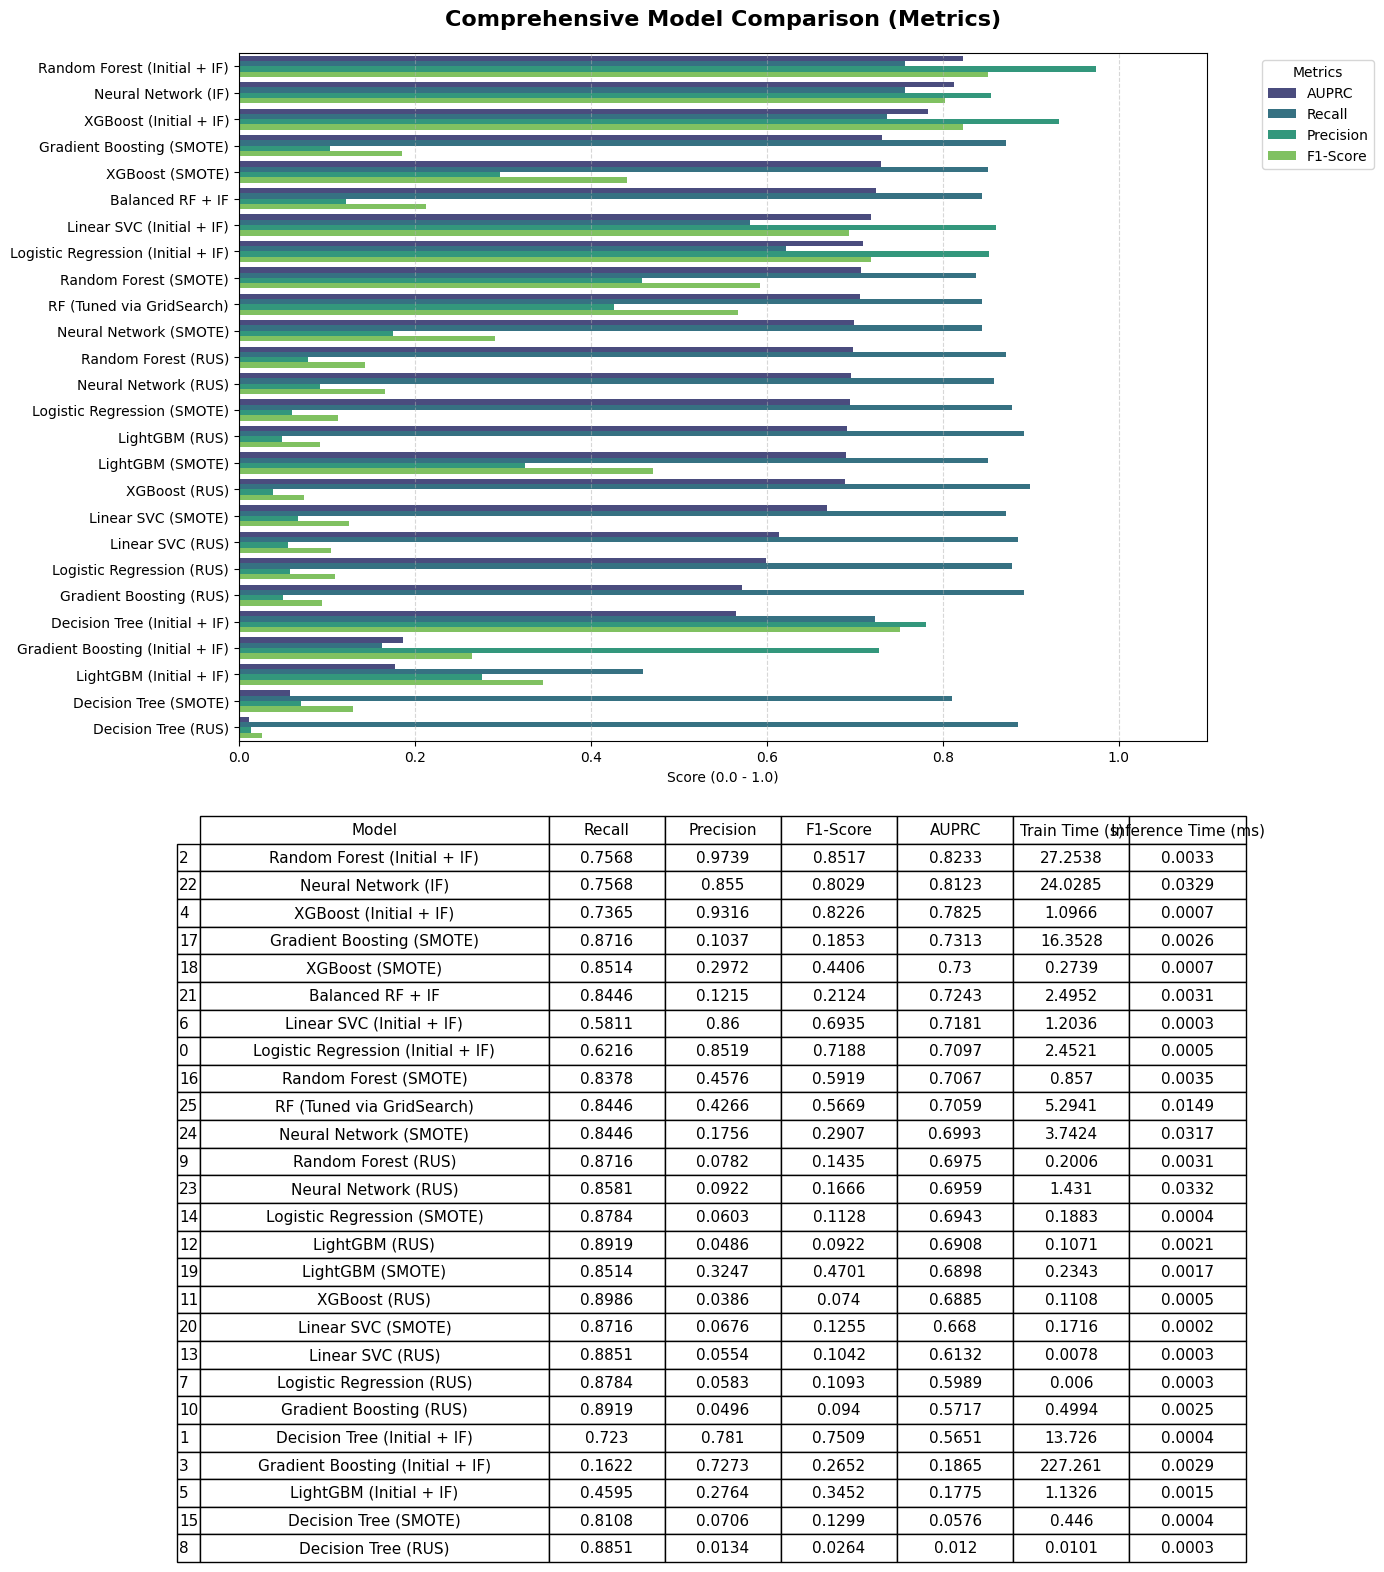

C:\Users\WIsuy\AppData\Local\Temp\ipykernel_20376\748611863.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results.sort_values('Train Time (s)'), y='Model', x='Train Time (s)', palette='magma')


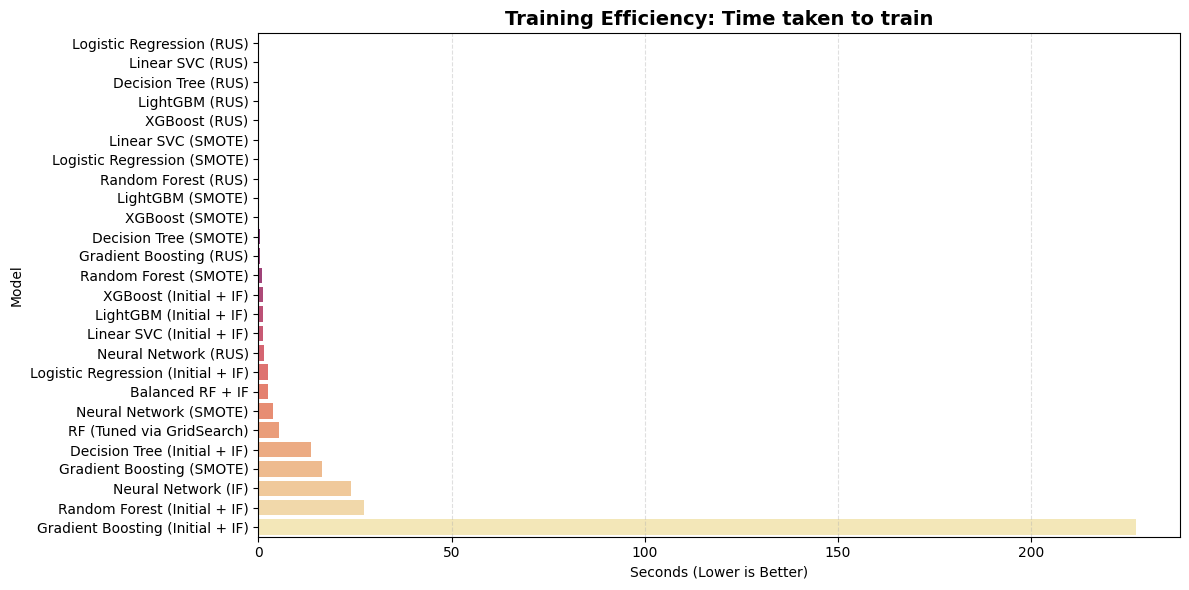

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table

df_results = pd.DataFrame(performance_data).sort_values(by='AUPRC', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 1]})

df_melted = df_results.melt(id_vars='Model', value_vars=['AUPRC', 'Recall', 'Precision', 'F1-Score'])

sns.barplot(data=df_melted, y='Model', x='value', hue='variable', ax=ax1, palette='viridis')
ax1.set_title('Comprehensive Model Comparison (Metrics)', fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Score (0.0 - 1.0)')
ax1.set_ylabel('')
ax1.set_xlim(0, 1.1)
ax1.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

ax2.axis('off') 
tbl = table(ax2, df_results.round(4), loc='center', cellLoc='center', colWidths=[0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1.2, 1.8)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.sort_values('Train Time (s)'), y='Model', x='Train Time (s)', palette='magma')
plt.title('Training Efficiency: Time taken to train', fontsize=14, weight='bold')
plt.xlabel('Seconds (Lower is Better)')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

***The Confusion Matrix***

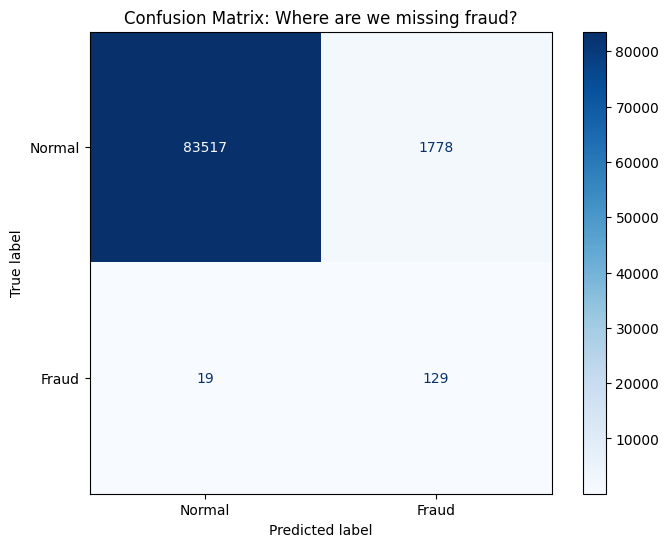

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Where are we missing fraud?')
plt.show()